__Imports :__

In [2]:
import requests
import os, re
from datetime import datetime
from bs4 import BeautifulSoup
import json
import random

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import universities
from unidecode import unidecode
from country_named_entity_recognition import find_countries
import country_converter as coco

from typing import List, Dict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Scrapper file :

In [3]:
# Scraper class for extracting nodes and links from nature.com articles
class Scraper:
    def __init__(self):
        # Initializing class variables
        self.base_url = "https://www.nature.com"
        self.universities = {}         # Dictionary to store universities and their occurrences
        self.collabs = {}              # Dictionary to store collaborations between universities
        self.mapping_univs = {}        # Mapping old university names to new names
        self.links_saved = []          # List to save article links used after

    # Method to load collaboration data from a JSON file
    def load_collabs(self, filename):
        with open(filename, 'r') as file:
            self.collabs = json.load(file)

    # Method to load university data from a JSON file
    def load_universities(self, filename):
        with open(filename, 'r') as file:
            self.universities = json.load(file)

    # Method to load saved links from a JSON file
    def load_links(self, filename):
        with open(filename, 'r') as file:
            self.links = json.load(file)

    # Method to save universities data to a JSON file
    def save_universities_in_file(self):
        with open('universities.json', 'w') as fp:
            json.dump(self.universities, fp)

    # Method to save collaborations data to a JSON file
    def save_collabs_in_file(self):
        with open('collabs.json', 'w') as fp:
            json.dump(self.collabs, fp)

    # Method to save saved links to a JSON file
    def save_links_in_file(self):
        with open('links.json', 'w') as fp:
            json.dump(self.links_saved, fp)

    # Method to retrieve HTML content of a given URL and parse it using BeautifulSoup
    def retrieve_url(self, url: str) -> BeautifulSoup:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        return soup

    # Method to create a mapping between old and new university names
    def create_map(self):
        for new_name in self.universities.keys():        
            for old_name in self.universities[new_name]['init_names']:
                if old_name not in self.mapping_univs:
                    self.mapping_univs[old_name] = new_name

    # Method to extract universities and collaboration data from nature.com articles
    def extract_universities(self):
        articles_counter = 1
        page = 1

        while True:
            search_url = f'{self.base_url}/search?journal=srep&article_type=research&subject=mathematics-and-computing&date_range=last_year&order=relevance&page={page}'
            soup = self.retrieve_url(search_url)

            all_atags = soup.find_all('a', {'data-track-action': 'view article'})

            if len(all_atags) == 0:
                break

            for atag in all_atags:
                random.seed(articles_counter)

                if(random.random() < 0.5):
                    self.parse_page(self.base_url + atag['href'], univs=True, collabs=False)
                    print(f"[EXTRACTING UNIVS] {articles_counter} articles and {len(self.universities)} universities found")
                else:
                    self.links_saved.append(atag['href'])
                    print(f"[EXTRACTING UNIVS] {articles_counter} articles found and {len(self.links_saved)} links saved")

                articles_counter += 1            
            page += 1

    # Method to extract collaboration data from nature.com articles
    def extract_collabs(self):
        articles_counter = 1
        page = 1

        while True:
            search_url = f'{self.base_url}/search?journal=srep&article_type=research&subject=mathematics-and-computing&date_range=last_year&order=relevance&page={page}'
            soup = self.retrieve_url(search_url)

            all_atags = soup.find_all('a', {'data-track-action': 'view article'})

            if len(all_atags) == 0:
                break

            for atag in all_atags:
                random.seed(articles_counter)

                if(random.random() < 0.5):
                    self.parse_page(self.base_url + atag['href'], univs=False, collabs=True)
                    print(f"[EXTRACTING COLLABS] {articles_counter} articles done")
                articles_counter += 1  
            page += 1

    # Method to print statistics about extracted data
    def print_stats(self):
        print(f'Number of nodes: {len(self.universities)}')
        links = 0
        links_with_fields = 0

        for u1 in self.collabs:
            for u2 in self.collabs[u1]:
                for u3 in self.collabs[u1][u2]:
                    links_with_fields += 1
                links += 1

        print(f'Number of links (without fields): {links}')
        print(f'Number of links (with fields): {links_with_fields}')

    # Method to parse the content of an article page and update dictionaries
    def parse_page(self, url: str, univs=True, collabs=True):
        soup = self.retrieve_url(url)

        try:
            # Find universities and update dictionaries
            authors_all = soup.findAll('p', class_='c-article-author-affiliation__address')
            subjects_all = soup.findAll('meta', {'name': 'dc.subject'})
        
            if univs:
                for s in authors_all:        
                    university = s.text        
                    if university not in self.universities:
                        self.universities[university] = 1
                    else:
                        self.universities[university] += 1

            if collabs:
                for s in authors_all:
                    try:
                        university = self.mapping_univs[s.text]

                        if university not in self.collabs:
                            self.collabs[university] = {}

                        alreadyAddedUniv = []
                        for s2 in authors_all:
                            try:
                                other_university = self.mapping_univs[s2.text]
                                if other_university not in alreadyAddedUniv:
                                    for sub in subjects_all:
                                        subject = sub.get('content')
                                        if university != other_university:
                                            if other_university not in self.collabs[university]:
                                                self.collabs[university][other_university] = {}

                                            if subject not in self.collabs[university][other_university]:
                                                self.collabs[university][other_university][subject] = 0

                                            self.collabs[university][other_university][subject] += 1
                                    alreadyAddedUniv.append(other_university)
                            except:
                                continue
                    except:
                        continue

        except Exception as error:
            print("[ERROR] Parse page: ", error) 

    # Method to preprocess university data
    def preprocess_universities(self):
        universities = {}

        for entry, count in self.universities.items():
            # Split the entry by commas and iterate through the parts
            parts = entry.split(',')

            # Look for patterns that match university names
            university = None
            for part in reversed(parts):
                if any(keyword in part for keyword in ["Polytechnic", "NIT", "MIT", "Politecnico", "Escuela", "École", "Institut", "Universitat", "Università", "Universität", "Universidad", "University", "Institute", "Ecole", "Universiti", "Université", "College", "School", "MIT"]):
                    university = part.strip()
                    break

            # If a university name is found, store the entry in the dictionary
            if university:
                if university in universities:
                    universities[university]['init_names'].append(entry)
                    universities[university]['count'] += count
                else:
                    universities[university] = {"init_names": [entry], "count": count}
            else:
                print(f"Not accepted this uni: {entry}")
            
        model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

        university_names = list(universities.keys())

        embeddings = model.encode(university_names, convert_to_tensor=True)

        similarity_matrix = cosine_similarity(embeddings, embeddings)

        threshold = 0.92
        similar_pairs = []

        for i in range(len(university_names)):
            for j in range(i + 1, len(university_names)):
                if similarity_matrix[i, j] > threshold:
                    similar_pairs.append((university_names[i], university_names[j]))

        similar_groups = []

        for pair in similar_pairs:
            found = False
            for group in similar_groups:
                if pair[0] in group or pair[1] in group:
                    group.add(pair[0])
                    group.add(pair[1])
                    found = True
                    break
            if not found:
                similar_groups.append({pair[0], pair[1]})

        similar_groups = [list(group) for group in similar_groups]

        for gr in similar_groups:
            first_uni = gr[0]

            for uni in gr[1:]:
                if first_uni in universities and uni in universities:
                    if 'init_names' not in universities[first_uni]:
                        universities[first_uni]['init_names'] = []
                    if 'count' not in universities[first_uni]:
                        universities[first_uni]['count'] = 0
                    universities[first_uni]['init_names'].extend(universities[uni].get('init_names', []))
                    universities[first_uni]['count'] = universities.get(first_uni, {}).get('count', 0) + universities.get(uni, {}).get('count', 0)
                    universities.pop(uni)

        universities = {key.strip(): value for key, value in universities.items()}

        self.universities = universities

# Creating the networks:
Not all paper in nature.com had the country has last item, so we need to opt for a different method. Probably, picking one string and splitting in according to commas, and checking if any element of the derived list has a match in 'find_countries' is a generalized version of the code

In [4]:
def create_edges(data, u1,u2):
    edges = []
    overall_weight = 0
    for collab in data.collabs[u1][u2].items():
        #print(collab)
        attr_dict = {'subject':collab[0], 'weight':collab[1]}
        edge = (u1, u2, attr_dict)
        edges.append(edge)

        overall_weight+=collab[1]

    #Edge with topic 'All'
    overall_edge = (u1,u2, {'subject':'All','weight':overall_weight})
    edges.append(overall_edge)
    return edges        

In [5]:
data = Scraper()
data.load_universities("universities.json")
data.load_collabs("collabs.json")

inserted_universities = {}
edges = []
nodes = []

list_of_weirdos =  ['117997',
 '119049',
 '119192',
 '125412',
 '141980',
 '1591634311',
 '162600',
 '199034',
 '236016',
 '354340',
 '603950',
 '630090',
 '634050',
 '830-0011',
 '970',]

#Without this, only northern IReland is left apart, but it's not even a country tehnically
mistakes_in_countries = {
    'Brasil':'Brazil',
    'Espana':'Spain',
    'UAE': 'United arab emirates',
    'ROC': 'Taiwan',
    'Northern Ireland': 'Ireland'
}

cc = coco.CountryConverter()

for uni, values in data.universities.items():
    #Clean unicode characters like egne
    country = unidecode(values['country'])
    #Clean spelling mistakes, or not recognized names
    country = mistakes_in_countries.get(country,country)
    cc.convert(country, to = 'name_short')
    nodes.append((uni, {'country':values['country']}))
    
        
    
#Check if every country inserted is in fact a country
distinct_nodes = set([attr['country'] for node, attr in nodes])
#print(distinct_nodes)

for u1 in data.collabs:
    inserted_universities[u1] = True
    for u2 in data.collabs[u1]:
        if not inserted_universities.get(u2,False):
            tmp_edges = create_edges(data,u1,u2)
            edges.extend(tmp_edges)

G = nx.MultiGraph()
G.add_nodes_from(nodes)
keys = G.add_edges_from(edges) #Keys are very important, they allow us to distinguish between edges


print(f"Number of nodes is {len(G.nodes())}")
print(f"Number of edges is {len(G.edges())}")

634050 not found in ISOnumeric
119049 not found in ISOnumeric
141980 not found in ISOnumeric
117997 not found in ISOnumeric
119192 not found in ISOnumeric
970 not found in ISOnumeric
1591634311 not found in ISOnumeric
199034 not found in ISOnumeric
162600 not found in ISOnumeric
630090 not found in ISOnumeric
354340 not found in ISOnumeric
603950 not found in ISOnumeric
236016 not found in ISOnumeric
125412 not found in ISOnumeric
830-0011 not found in regex


Number of nodes is 3032
Number of edges is 12772


In [6]:
##How many isolated nodes?
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes is {len(isolated_nodes)}")

Number of isolated nodes is 817


In [7]:
G.remove_nodes_from(isolated_nodes)
print(f"Number of nodes after removal is {len(G.nodes())}")

Number of nodes after removal is 2215


## Subject distribution

From now on, we will define a color coding for every subject, and use such color coding for visual representations.

We picked colors from the nature.com color coding, so
* for the field of physical sciences, we have shades of blue
* for the field of Earth and Environmental sciences, we have shades of green
* for the field of Biological sciences, we have shades of purple
* for the field of Health sciences, we have shades of red

In [8]:
subj_color_mapping = {
    'health-care': '#FFBF00', #Orange, yellowish
    'mathematics-and-computing': '#00008B', #Blue
    'genetics': '#702963', #Purple
    'ecology': '#50C878', #Green
    'diseases': '#FF5F1F', #Orange danger
    'microbiology': '#CCCCFF',  #Purple
    'physics': '#7393B3', #Blue
    'All':'#000000' #Black
}

['health-care',
 'mathematics-and-computing',
 'genetics',
 'ecology',
 'diseases',
 'microbiology',
 'physics']


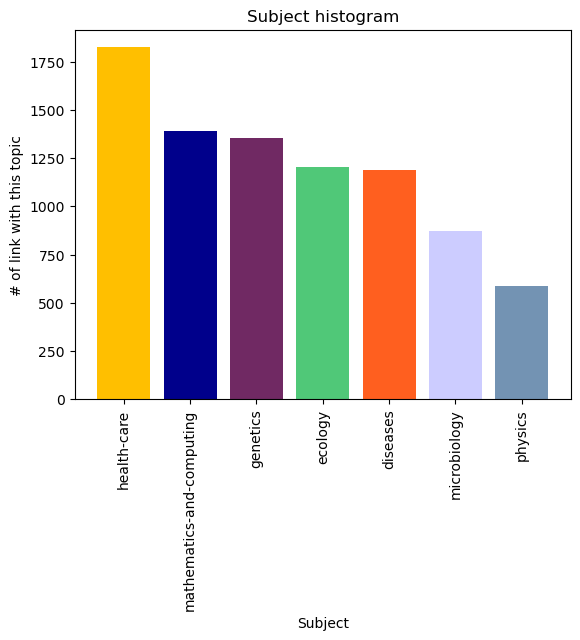

In [9]:
def subject_distribution(subjects, first_n):
    distrib = {}
    for subject, weight in subjects:
        if subject != 'All':
            distrib[subject] = distrib.get(subject,0) + weight
    width = 0.8 # width of the bars

    fig, ax = plt.subplots()

    ordered_items = sorted(distrib.items(),key=lambda x: x[1], reverse = True)[:first_n]
    xvalues = [subject for subject, value in ordered_items]
    yvalues = [value for subject, value in ordered_items]

    pprint(xvalues)
    
    colors = [subj_color_mapping[subject] for subject in xvalues]

    rects1 = ax.bar(xvalues, yvalues, width, color=colors)
    ax.set_title("Subject histogram")
    ax.set_xlabel("Subject")
    ax.set_xticks(range(len(xvalues)),xvalues, rotation = 90) # set the position of the x ticks
    ax.set_ylabel("# of link with this topic")
    plt.show()


#Analyzing subjects
subjects = [(attr['subject'], attr['weight']) for node1, node2, attr in G.edges(data=True)]
first_n = 10
subject_distribution(subjects, first_n)
subject_set = set([subj for subj, weight in subjects])

# Network analysis stuff 

### Network analysis methods (To split later in the corresponding chunks)

In [28]:
def create_subgraph(G, subj):
    edges = set([(node1, node2, key) for node1, node2 in G.edges() for key, value in G.get_edge_data(node1, node2).items() if value['subject'] == subj])
    graph = G.edge_subgraph(edges)
    print(f"Graph on \033[1m{subj}\033[0m")
    print(f"\thas {len(graph.edges())} nodes")
    print(f"\thas {len(graph.nodes())} edges\n")
    return graph
    
def remove_isolated_nodes(G, subj):
    ##How many isolated nodes?
    isolated_nodes = list(nx.isolates(G))
    print(f"Number of isolated nodes for \033[1m{subj}\033[0m is {len(isolated_nodes)}")
    
    if isolated_nodes:
        G.remove_nodes_from(isolated_nodes)
        print(f"\t remaining {len(G.nodes())} nodes")
        
##How many connected components? And how big are they?
def connected_component_size_distribution(G, subj):
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    
    print(f"Subject \033[1m{subj}\033[0m has:")
    print(f"\t{len(Gcc)} connected components \n")
    
    Gcc_len_distrib = [len(cc) for cc in Gcc]
    
    return Gcc_len_distrib


def populate_plot(data, subj, fig, grid, labels):
    dmax = max(data[:])
    dmin = min(data[:])
    
    #Bin plot
    bins = np.arange(dmin, dmax+2)
    hist, bins = np.histogram(data[:], bins)
    
    ax = fig.add_subplot(grid) 
    ax.bar(bins[:-1], hist, width=1, align='center', edgecolor='k', color = subj_color_mapping[subj])
    ax.set_title(f'{subj}')
    ax.set_xlabel(labels['xlabel'])
    ax.set_ylabel('How many')
    return ax

def drawNetwork2D(G, subj, fig, grid, labels, scaling_factor=1):   
    #We draw only the biggest component/we should use the biggest component in general
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
        
    #color_list = [subj_color_mapping[attr['subject']] for node1, node2, attr in G.edges(data=True)]
    color = subj_color_mapping[subj]
    size_measure = dict(Gcc.degree)
    #pos = nx.kamada_kawai_layout(Gcc)
    pos = nx.spring_layout(Gcc)
    nodes_conf = {'node_size':[v*scaling_factor for v in size_measure.values()], 'linewidths':1, 'edgecolors':'black'}
    edges_conf = {'width':0.7, 'alpha':0.8, 'edge_color':color}

    ax = fig.add_subplot(grid)
    nx.draw_networkx_nodes(Gcc, pos=pos, ax = ax, **nodes_conf)
    nx.draw_networkx_edges(Gcc, pos=pos, ax=ax, **edges_conf)
    ax.set_title(f"{labels['title']} of {subj} network")
    ax.set_axis_off()
    return ax

#Only requires subject associated with list of data to barplot
def create_visual_graph(subj_data_dict, labels, category='bar'):
    fig = plt.figure("Connected components size distribution", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(4, 2)
    
    axes = []
    for i, grid in enumerate(axgrid):
        if category == 'bar':
            axes.append(populate_plot(list(subj_data_dict.values())[i], list(subj_data_dict.keys())[i], fig, grid, labels))
        if category == 'network':
            axes.append(drawNetwork2D(list(subj_data_dict.values())[i], list(subj_data_dict.keys())[i], fig, grid, labels))
        
    fig.tight_layout()
    plt.show()

### Creating the subgraphs
We are not going to analyze our network in it's entirety. We will separate it into subnetworks such as:
* One subnetwork that includes all links between universities, regardless the subjects
* One subnetwork per subject

In [29]:
graphs = {}
for subj in subj_color_mapping.keys():
    graphs[subj] = create_subgraph(G, subj)

Graph on health-care
	has 1367 nodes
	has 702 edges

Graph on mathematics-and-computing
	has 1166 nodes
	has 602 edges

Graph on genetics
	has 999 nodes
	has 461 edges

Graph on ecology
	has 1068 nodes
	has 445 edges

Graph on diseases
	has 863 nodes
	has 464 edges

Graph on microbiology
	has 676 nodes
	has 434 edges

Graph on physics
	has 496 nodes
	has 329 edges

Graph on All
	has 6137 nodes
	has 2215 edges



### Removing isolated nodes

In [30]:
for subj, graph in graphs.items():
    remove_isolated_nodes(graph, subj)

Number of isolated nodes for health-care is 0
Number of isolated nodes for mathematics-and-computing is 0
Number of isolated nodes for genetics is 0
Number of isolated nodes for ecology is 0
Number of isolated nodes for diseases is 0
Number of isolated nodes for microbiology is 0
Number of isolated nodes for physics is 0
Number of isolated nodes for All is 0


### Connected Component size distribution
And now, we plot.

__For future versions, maybe we need to fix the x range for the plots (?)__ 

Subject health-care has:
	122 connected components 

Subject mathematics-and-computing has:
	109 connected components 

Subject genetics has:
	79 connected components 

Subject ecology has:
	72 connected components 

Subject diseases has:
	99 connected components 

Subject microbiology has:
	107 connected components 

Subject physics has:
	74 connected components 

Subject All has:
	137 connected components 



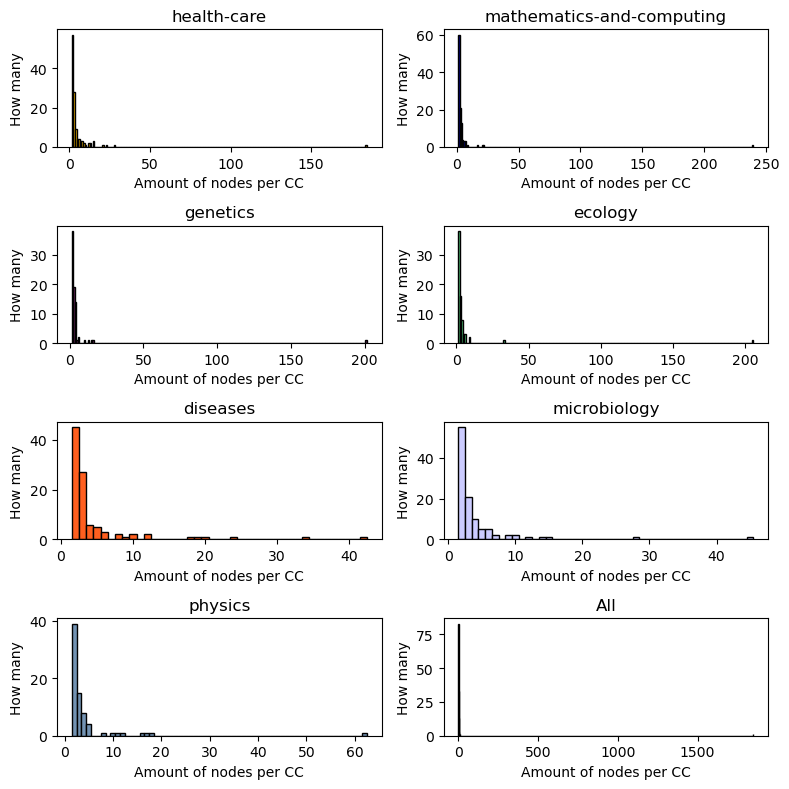

In [31]:
subj_cc_size_dict = {}
labels = {'xlabel':'Amount of nodes per CC'}
for subject, graph in graphs.items():
    subj_cc_size_dict[subject] = connected_component_size_distribution(graph, subject)

create_visual_graph(subj_cc_size_dict, labels, 'bar')

We can see that in most cases, there is a component that far exceeds the others in terms of size. This is not true for topics such as "diseases" and "microbiology".

### Degree distribution and graph plotting

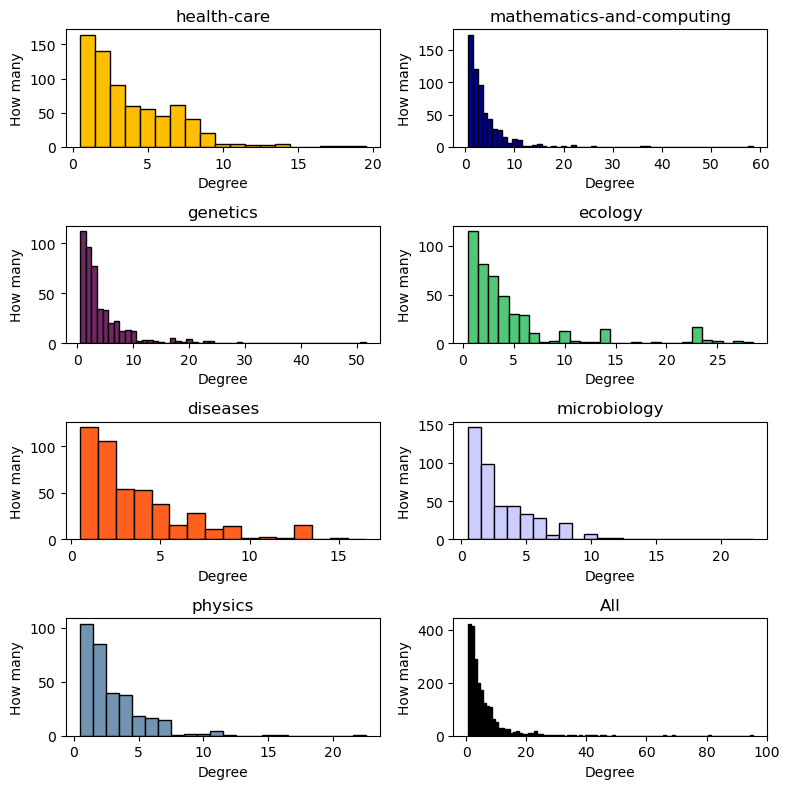

In [14]:
subj_degrees_dict = {}
labels = {'xlabel':'Degree'}
for subject, graph in graphs.items():
    subj_degrees_dict[subject] = sorted((d for n, d in graph.degree()), reverse=True)
    
create_visual_graph(subj_degrees_dict, labels, 'bar')

Comments about degree distributions (hard)

### 2D network plotting

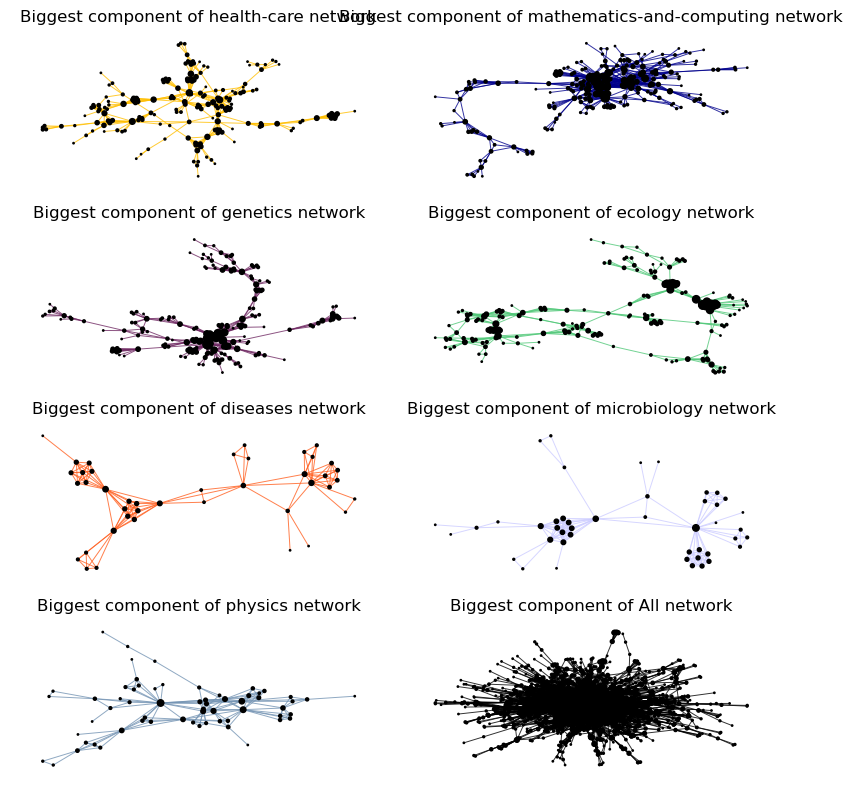

In [22]:
#Create a function for node coloring, returns a color for a given country passed to the function
def color_generator():
    return 


labels = {'title':'Biggest component'}
create_visual_graph(graphs, labels, 'network')

### 3D Network plotting

In [ ]:
'''
def drawNetwork3D(graph, positions):
    west_color = 'orange'
    east_color = 'blue'
    other_color = 'green'

    degrees = dict(graph.degree)
    node_sizes = [4 * deg for deg in degrees.values()]
    node_colors = [west_color if node['origin'] == 'west' else east_color for v, node in graph.nodes(data=True)]
    edge_colors = [east_color if graph.nodes[e[0]]['origin'] == 'east' and graph.nodes[e[1]]['origin'] == 'east' else west_color if graph.nodes[e[0]]['origin'] == 'west' and graph.nodes[e[1]]['origin'] == 'west' else other_color for e in graph.edges]

    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(111, projection='3d')

    xs = [pos[0] for pos in positions.values()]
    ys = [pos[1] for pos in positions.values()]
    zs = [node_size for node_size in node_sizes]

    alreadyDisplayed = []  
    i = 0
    for edge in graph.edges():
        node1 = positions[edge[0]]
        node2 = positions[edge[1]]
        alr = 0
        for (n1, n2) in alreadyDisplayed:
            if n1[0] == node1[0] and n1[1] == node1[1] and n2[0] == node2[0] and n2[1] == node2[1]:
                alr = 1

        # To make the graph clearer, we print only one connection between two rappers even if they are mutually linked (one pointing to the other and vice versa).
        if not alr:
            x_values = [node1[0], node2[0]]
            y_values = [node1[1], node2[1]]
            z_values = [node_sizes[list(graph.nodes).index(edge[0])], node_sizes[list(graph.nodes).index(edge[1])]]

            ax.plot(x_values, y_values, z_values, color=edge_colors[i], alpha=0.1)
            alreadyDisplayed.append((node1, node2))
            alreadyDisplayed.append((node2, node1))
        i = i + 1

    ax.scatter(xs, ys, zs, c=node_colors, s=node_sizes, depthshade=True)

    legend_labels = {
        'West': west_color,
        'East': east_color,
        'Other': other_color
    }
    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in legend_labels.items()]
    ax.legend(handles=custom_legend, title="Origin", loc='upper right')

    ax.set_title("3D network of rappers")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.show()

positions = nx.spring_layout(G_largest_comp, k=1.2, scale=8)
drawNetwork3D(G_largest_comp, positions=positions)
'''

#I HAVE NO IDEA

### Centrality measures

In [38]:
def compute_betweennes_centrality(G,subj,n_first):
    centrality = nx.betweenness_centrality(G, weight='weight') #We should maybe put a seed to stuff, for reproducibility
    centrality_list = sorted(centrality.items(), key=lambda x:x[1], reverse = True)
    
    most_central_universities = centrality_list[:n_first]
    print(f"Most central uni's of \033[1m{subj}\033[0m")
    pprint(most_central_universities)
    print("\n")
    return 

n_first = 3
for subj, graph in graphs.items():
    compute_betweennes_centrality(graph, subj, n_first)

Most central unis of health-care
[('University of Southern California', 0.04044725222471302),
 ('Medical University Vienna', 0.025564431764146408),
 ('Nanyang Technological University', 0.0189412404048638)]


Most central unis of mathematics-and-computing
[('Lebanese American University', 0.05829453825197806),
 ('Islamic Azad University', 0.042382384341406135),
 ('Research Institute Shahid Beheshti University of Medical Science',
  0.03989646884821595)]


Most central unis of genetics
[('University of Southern California', 0.08233878956878024),
 ('University College London', 0.07254782838329299),
 ('University of Cambridge', 0.06264090177133655)]


Most central unis of ecology
[('The University of British Columbia', 0.1119619645296846),
 ('University of Oxford', 0.10702242361384573),
 ('Université de Montréal', 0.10496613995485328)]


Most central unis of diseases
[('University of New South Wales', 0.004295611824152398),
 ('University of Technology Sydney', 0.0039269585705870805),
 ('U

# Community detection stuff

### Community using algorithm (maybe more than one, and compare them, explaining how they work)

### Community split according to countries

### Significance test to see the difference

# Text processing stuff

### Word cloud

### Dictionary based topic analysis